In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [2]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [3]:
input = '/home/kchakola/sfuhome/EDS_5.csv.gz'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [4]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,X as Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

In [5]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|1.007813| 1.566565|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|1.003906| 0.605977|
|2018-07-09 12:00:...|     1.0|-0.354365|
|2018-07-09 12:00:...|     1.0|-0.354365|
+--------------------+--------+---

In [6]:
scaledData.sort(desc("Zscale")).show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-08-06 21:07:...|1.203125|49.586623|
|2018-07-09 22:51:...|1.167969|40.943052|
|2018-07-09 23:53:...|1.160156|39.022122|
|2018-07-11 10:22:...| 1.15625| 38.06178|
|2018-07-12 11:01:...|1.152344|37.101438|
|2018-07-11 17:06:...|1.148438|36.141096|
|2018-07-09 23:54:...|1.144531|35.180508|
|2018-07-25 13:01:...|1.132813|32.299481|
|2018-07-12 10:26:...|1.132813|32.299481|
|2018-07-19 09:58:...|1.128906|31.338893|
|2018-08-02 10:16:...|   1.125|30.378551|
|2018-07-13 13:33:...|   1.125|30.378551|
|2018-07-21 10:58:...|   1.125|30.378551|
|2018-08-01 16:52:...|1.121094|29.418209|
|2018-07-19 09:50:...|1.121094|29.418209|
|2018-07-15 16:31:...|1.109375|26.536937|
|2018-07-27 14:08:...|1.105469|25.576594|
|2018-07-09 23:54:...|1.101563|24.616252|
|2018-07-19 09:58:...|1.101563|24.616252|
|2018-07-19 11:22:...|1.101563|24.616252|
+--------------------+--------+---

In [7]:
scaledData.sort("Zscale").show()

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-07-16 18:21:...|0.644531|-87.751155|
|2018-07-09 21:31:...|0.699219|-74.305382|
|2018-07-29 13:28:...|0.769531| -57.01824|
|2018-07-12 11:01:...|0.800781|-49.335011|
|2018-07-26 11:15:...|0.808594| -47.41408|
|2018-07-09 13:08:...|0.816406|-45.493396|
|2018-07-09 22:51:...|0.820313|-44.532808|
|2018-07-26 11:12:...|0.824219|-43.572466|
|2018-07-26 11:15:...|0.832031|-41.651782|
|2018-07-26 11:15:...|0.835938|-40.691194|
|2018-07-26 08:08:...|0.835938|-40.691194|
|2018-07-19 11:22:...|0.835938|-40.691194|
|2018-07-26 11:15:...| 0.84375|-38.770509|
|2018-08-03 20:05:...|0.847656|-37.810167|
|2018-07-26 11:15:...|0.851563|-36.849579|
|2018-07-19 11:22:...|0.855469|-35.889237|
|2018-07-26 11:12:...|0.855469|-35.889237|
|2018-07-09 21:31:...|0.863281|-33.968553|
|2018-07-26 11:12:...|0.863281|-33.968553|
|2018-07-26 11:15:...|0.867188|-33.007965|
+----------

In [84]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Zscale from scaledData where timestamp between '2018-07-19 11:22:00' and '2018-07-19 11:23:00'").cache()

In [85]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+----------+-------------------+
|           timestamp|    Zscale|         timestamp1|
+--------------------+----------+-------------------+
|2018-07-19 11:22:...| -0.354365|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -5.156321|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -9.958278|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -12.83955|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-10.918866|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -8.037594|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -8.997936|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-10.918866|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -8.997936|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-11.879208|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-10.918866|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-10.918866|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -9.958278|2018-07-19 11:22:00|
|2018-07-19 11:22:...| -12.83955|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-13.799892|2018-07-19 11:22:00|
|2018-07-19 11:22:...|-13.79

In [86]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+--------------------+----------+-------------------+--------------------+
|           timestamp|    Zscale|         timestamp1|       movingAverage|
+--------------------+----------+-------------------+--------------------+
|2018-07-19 11:22:...| -0.354365|2018-07-19 11:22:06|           -0.354365|
|2018-07-19 11:22:...| -0.354365|2018-07-19 11:22:06|            0.285945|
|2018-07-19 11:22:...|  1.566565|2018-07-19 11:22:06|            0.606059|
|2018-07-19 11:22:...|  0.605977|2018-07-19 11:22:06|            0.926173|
|2018-07-19 11:22:...|  0.605977|2018-07-19 11:22:06|            0.285863|
|2018-07-19 11:22:...| -0.354365|2018-07-19 11:22:06|            0.285863|
|2018-07-19 11:22:...|  0.605977|2018-07-19 11:22:06|           -0.034251|
|2018-07-19 11:22:...| -0.354365|2018-07-19 11:22:06|            0.285863|
|2018-07-19 11:22:...|  0.605977|2018-07-19 11:22:06|-0.35436500000000004|
|2018-07-19 11:22:...| -1.314707|2018-07-19 11:22:06| -0.9945930000000001|
|2018-07-19 11:22:...| -2

In [87]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [88]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 146 ms


### Plots of Normal data

In [191]:
roundData = scaledData.withColumn("Zround", functions.round(scaledData['Zscale']).cast('integer'))

roundData.show()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|1.007813| 1.566565|     2|
|2018-07-09 12:00:...|1.003906| 0.605977|     1|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|1.003906| 0.605977|     1|
|2018-07-09 12:00:...|1.003906| 0.605977|     1|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:...|1.003906| 0.605977|     1|
|2018-07-09 12:00:...|1.003906| 0.605977|     1|
|2018-07-09 12:00:...|     1.0|-0.354365|     0|
|2018-07-09 12:00:..

In [192]:
df_round = roundData.groupby('Zround').agg(functions.count('Zround').alias('count'))
df_round.show()

+------+--------+
|Zround|   count|
+------+--------+
|    31|       1|
|   -13|   18837|
|   -33|       2|
|   -20|      65|
|    -1| 1531113|
|   -17|     832|
|   -21|      73|
|    27|       1|
|    26|       1|
|   -10|   28154|
|   -44|       1|
|   -11|   31146|
|    12|    4835|
|   -27|       5|
|    22|      10|
|   -15|    4968|
|   -37|       1|
|     1|25117954|
|   -42|       1|
|   -39|       1|
+------+--------+
only showing top 20 rows



In [12]:
df_round.toPandas().to_csv("lift5_Zround.csv", header=True)

In [190]:
roundData.createOrReplaceTempView("roundDatap")
roundp_df = spark.sql("select timestamp, Z, Zscale from roundDatap where Zscale > -11.5 and Zscale < -10.5").cache()

roundp_df.show()

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:01:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:07:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:09:...|0.957031|-10.918866|
|2018-07-09 12:11:...|0.957031|-10.918866|
+----------

In [185]:
scaledData.createOrReplaceTempView("roundDatap1")
roundp_df1 = spark.sql("select timestamp,Zscale from roundDatap1 where timestamp between '2018-07-09 14:18:45' and '2018-07-09 14:19:00'").cache()

roundp_df1.show()

+--------------------+---------+
|           timestamp|   Zscale|
+--------------------+---------+
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...|-1.314707|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...|-0.354365|
|2018-07-09 14:18:...| 0.605977|
|2018-07-09 14:18:...| 0.605977|
+--------------------+---------+
only showing top 20 rows



In [186]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [187]:
%time roundp_df1_pandas = roundp_df1.select("*").toPandas()

CPU times: user 5.3 ms, sys: 404 µs, total: 5.7 ms
Wall time: 32.6 ms


### Plots

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text xticklabel objects>)

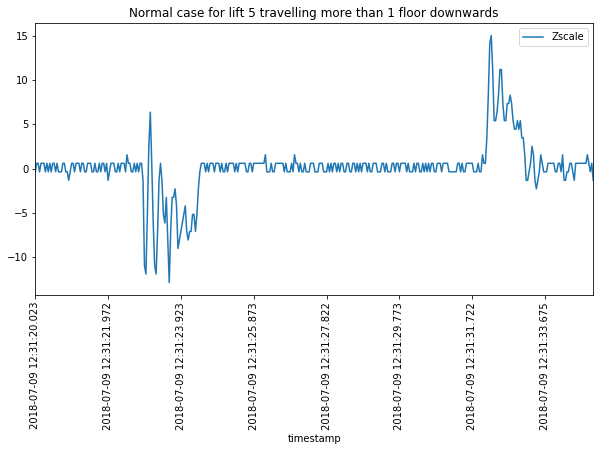

In [168]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 5 travelling more than 1 floor downwards")
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text xticklabel objects>)

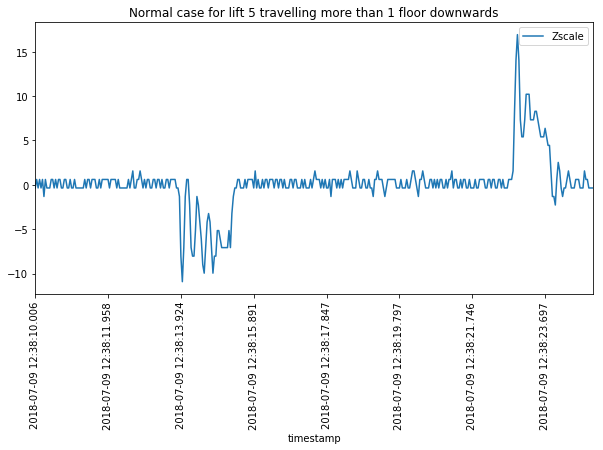

In [172]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 5 travelling more than 1 floor downwards")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text xticklabel objects>)

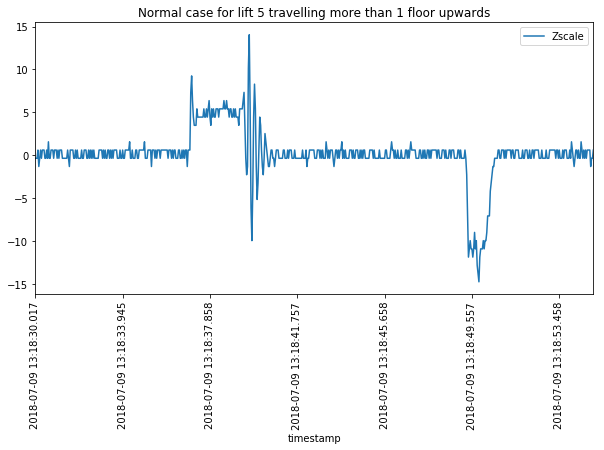

In [176]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 5 travelling more than 1 floor upwards")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text xticklabel objects>)

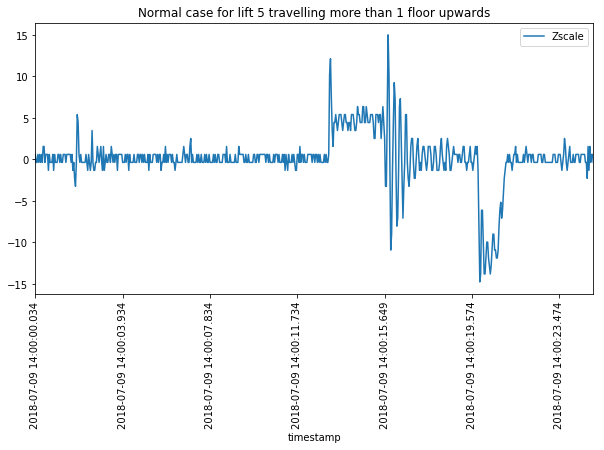

In [156]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 5 travelling more than 1 floor upwards")
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text xticklabel objects>)

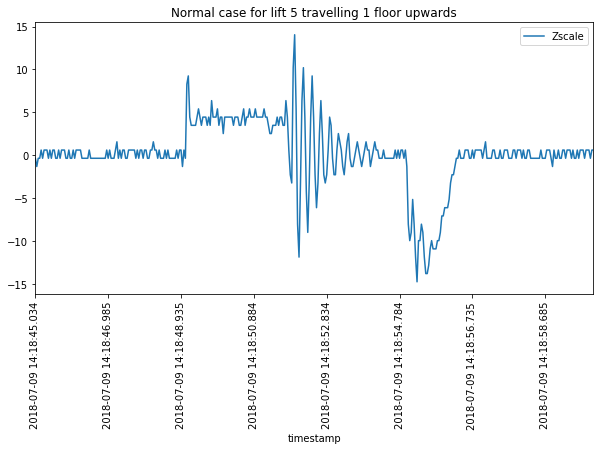

In [189]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 5 travelling 1 floor upwards")
plt.xticks(rotation=90)

### Plots of Anomalies detected for Lift 5. 10 different anomalies are plotted here

### Plots of Anomaly 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

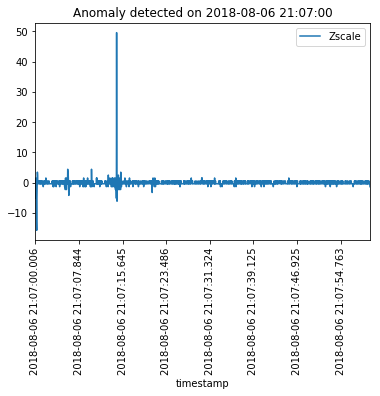

In [13]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-06 21:07:00")
plt.xticks(rotation=90)

In [14]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 130 ms, sys: 7.3 ms, total: 137 ms
Wall time: 602 ms


(array([736912.87986111, 736912.87997685, 736912.88009259, 736912.88020833,
        736912.88032407, 736912.88043981]),
 <a list of 6 Text xticklabel objects>)

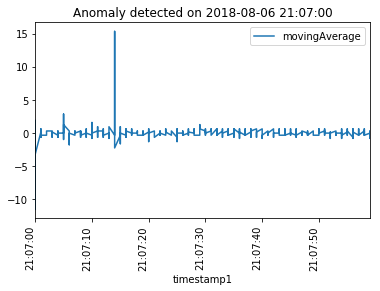

In [15]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-06 21:07:00")
plt.xticks(rotation=90)

### Plots of Anomaly 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

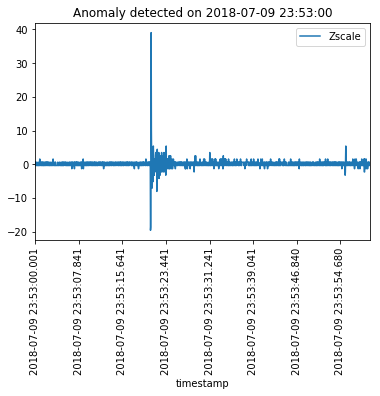

In [21]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 23:53:00")
plt.xticks(rotation=90)

In [22]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 133 ms, sys: 7.85 ms, total: 141 ms
Wall time: 562 ms


(array([736884.99513889, 736884.99525463, 736884.99537037, 736884.99548611,
        736884.99560185, 736884.99571759]),
 <a list of 6 Text xticklabel objects>)

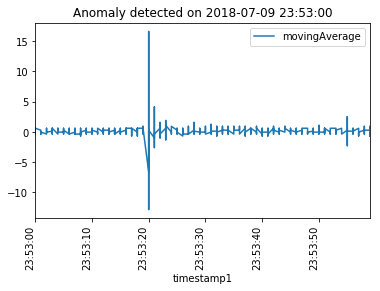

In [23]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 23:53:00")
plt.xticks(rotation=90)

### Plots of Anomaly 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

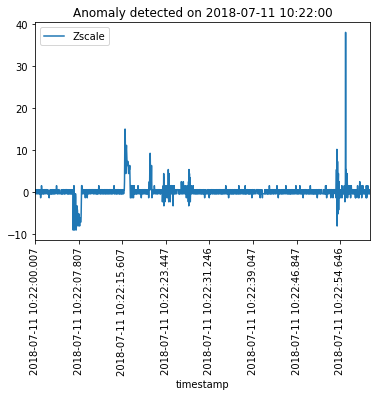

In [29]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 10:22:00")
plt.xticks(rotation=90)

In [30]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 133 ms, sys: 7.18 ms, total: 141 ms
Wall time: 531 ms


(array([736886.43194444, 736886.43206019, 736886.43217593, 736886.43229167,
        736886.43240741, 736886.43252315]),
 <a list of 6 Text xticklabel objects>)

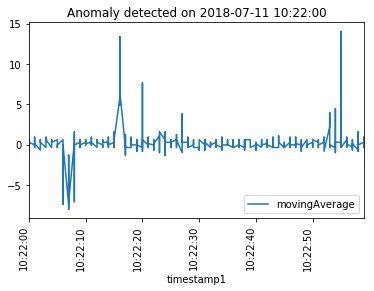

In [31]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 10:22:00")
plt.xticks(rotation=90)

### Plots of Anomaly 4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

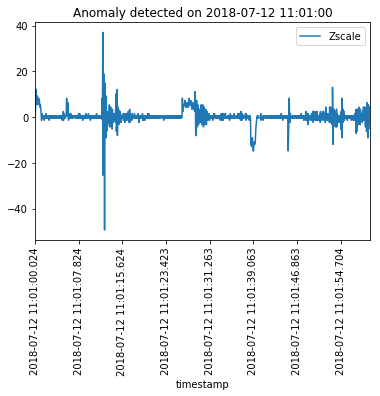

In [37]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 11:01:00")
plt.xticks(rotation=90)

In [38]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 128 ms, sys: 7.55 ms, total: 135 ms
Wall time: 512 ms


(array([736887.45902778, 736887.45914352, 736887.45925926, 736887.459375  ,
        736887.45949074, 736887.45960648]),
 <a list of 6 Text xticklabel objects>)

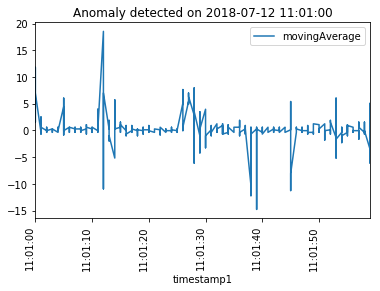

In [39]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 11:01:00")
plt.xticks(rotation=90)

### Plots of Anomaly 5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

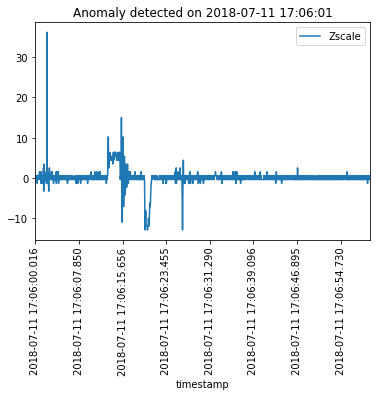

In [45]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 17:06:01")
plt.xticks(rotation=90)

In [46]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 142 ms, sys: 7.76 ms, total: 150 ms
Wall time: 489 ms


(array([736886.7125    , 736886.71261574, 736886.71273148, 736886.71284722,
        736886.71296296, 736886.7130787 ]),
 <a list of 6 Text xticklabel objects>)

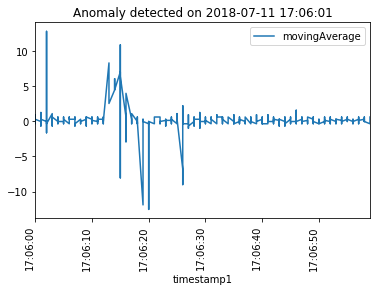

In [47]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 17:06:01")
plt.xticks(rotation=90)

### Plots of Anomaly 6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

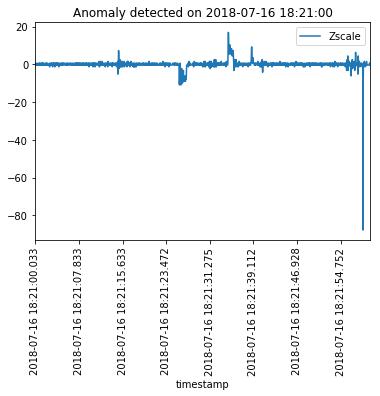

In [53]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 18:21:00")
plt.xticks(rotation=90)

In [54]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 132 ms, sys: 4.13 ms, total: 136 ms
Wall time: 443 ms


(array([736891.76458333, 736891.76469907, 736891.76481481, 736891.76493056,
        736891.7650463 , 736891.76516204]),
 <a list of 6 Text xticklabel objects>)

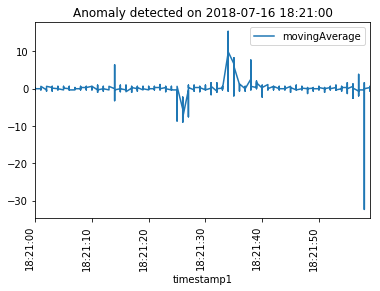

In [55]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 18:21:00")
plt.xticks(rotation=90)

### Plots of Anomaly 7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

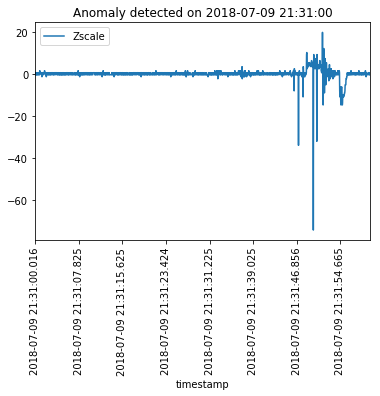

In [65]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 21:31:00")
plt.xticks(rotation=90)

In [66]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 137 ms, sys: 4.52 ms, total: 142 ms
Wall time: 385 ms


(array([736884.89652778, 736884.89664352, 736884.89675926, 736884.896875  ,
        736884.89699074, 736884.89710648]),
 <a list of 6 Text xticklabel objects>)

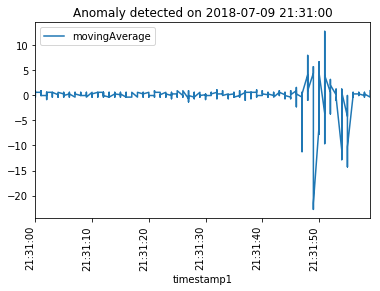

In [67]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 21:31:00")
plt.xticks(rotation=90)

### Plots of Anomaly 8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

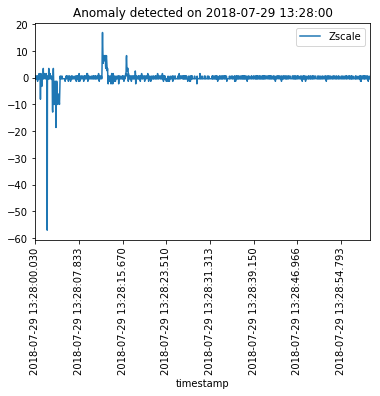

In [73]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-29 13:28:00")
plt.xticks(rotation=90)

In [74]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 133 ms, sys: 4.49 ms, total: 137 ms
Wall time: 379 ms


(array([736904.56111111, 736904.56122685, 736904.56134259, 736904.56145833,
        736904.56157407, 736904.56168981]),
 <a list of 6 Text xticklabel objects>)

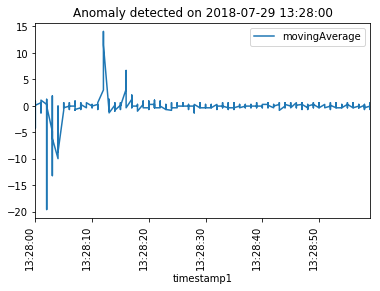

In [75]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-29 13:28:00")
plt.xticks(rotation=90)

### Plots of Anomaly 9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

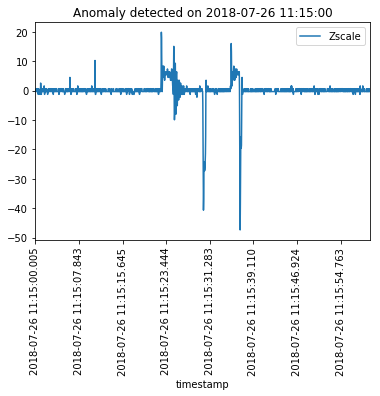

In [81]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 11:15:00")
plt.xticks(rotation=90)

In [82]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 125 ms, sys: 6.92 ms, total: 132 ms
Wall time: 374 ms


(array([736901.46875   , 736901.46886574, 736901.46898148, 736901.46909722,
        736901.46921296, 736901.4693287 ]),
 <a list of 6 Text xticklabel objects>)

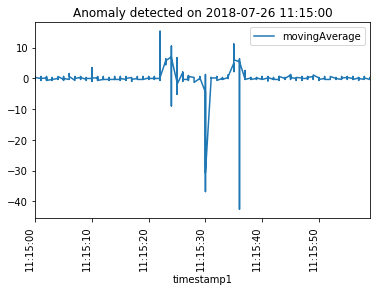

In [83]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 11:15:00")
plt.xticks(rotation=90)

### Plots of Anomaly 10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

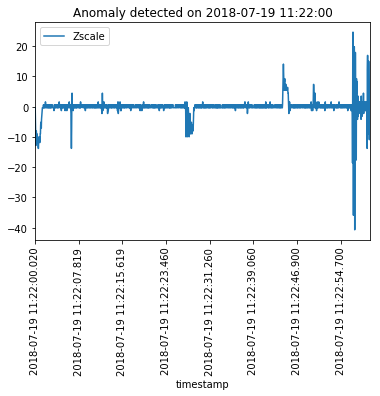

In [89]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-19 11:22:00")
plt.xticks(rotation=90)

In [90]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 123 ms, sys: 12.3 ms, total: 135 ms
Wall time: 399 ms


(array([736894.47361111, 736894.47372685, 736894.47384259, 736894.47395833,
        736894.47407407, 736894.47418981]),
 <a list of 6 Text xticklabel objects>)

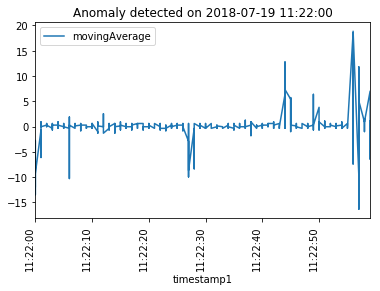

In [91]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-19 11:22:00")
plt.xticks(rotation=90)